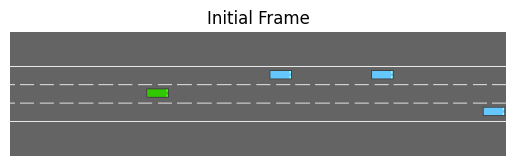

In [1]:
# Import libraries and make sure highway-env is installed properly
import highway_env
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
# pprint([env for env in gym.envs.registry.keys() if "highway   " in env])

# Create the environment with visual rendering
env = gym.make("highway-fast-v0", render_mode="rgb_array")
obs, info = env.reset()

# Render and show the first frame
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.title("Initial Frame")
plt.show()

env.close()

In [2]:
from pprint import pprint

# print the environment information
print("Environment Information:")
pprint(env.unwrapped.config)

import torch
import tensorboard

print(tensorboard.__version__)
print(torch.cuda.is_available())   # Should be True
print(torch.cuda.get_device_name(0))  # Should show GPU name


Environment Information:
{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 30,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 3,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 5,
 'vehicles_count': 20,
 'vehicles_density': 1}
2.17.1
True
NVIDIA GeForce RTX 3080


In [3]:
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor

def make_env(render_mode=None):
    def _init():
        config = {
            "action": {
                "type": "ContinuousAction"
            },
        }
        env = gym.make("highway-fast-v0", render_mode=render_mode, config=config)
        return Monitor(env)
    return _init


In [4]:
from stable_baselines3.common.vec_env import DummyVecEnv

env = DummyVecEnv([make_env(render_mode=None)])
# print the action space
print("Action Space:", env.action_space)

Action Space: Box(-1.0, 1.0, (2,), float32)


In [5]:
import optuna
import torch
import os
import json
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from optuna.pruners import MedianPruner

SAVE_DIR = "../trained_models/highway/SAC/"
os.makedirs(SAVE_DIR, exist_ok=True)

# Callback for pruning
class OptunaCallback(BaseCallback):
    def __init__(self, trial, eval_freq=2000, n_eval_episodes=3, verbose=0):
        super().__init__(verbose)
        self.trial = trial
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            reward, _ = evaluate_policy(self.model, self.training_env, n_eval_episodes=self.n_eval_episodes, deterministic=True)
            self.trial.report(reward, self.n_calls)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        return True

# Global storage
best_model = None
best_reward = -float("inf")

# Coarse and fine objective
def objective(trial, phase, coarse_params=None):
    global best_model, best_reward

    # === Coarse Phase ===
    if phase == "coarse":
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        gamma = trial.suggest_float("gamma", 0.9, 0.999)
        net_arch = trial.suggest_categorical("net_arch", [[64, 64], [128, 128], [256, 256]])
        learning_starts = trial.suggest_categorical("learning_starts", [1_000, 2_000])

        config = {
            "learning_rate": learning_rate,
            "gamma": gamma,
            "net_arch": net_arch,
            "learning_starts": learning_starts,
        }

    # === Fine Phase ===
    elif phase == "fine":
        assert coarse_params is not None, "Need coarse params for fine tuning"

        config = {
            **coarse_params,  # fixed
            "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256]),
            "tau": trial.suggest_float("tau", 0.005, 0.02),
            "train_freq": trial.suggest_categorical("train_freq", [1, 8, 16, 64]),
            "gradient_steps": trial.suggest_categorical("gradient_steps", [1, 8, 16, 64]),
            "ent_coef": trial.suggest_categorical("ent_coef", ["auto", "auto_0.1", "1e-2"]),
        }

    # Build env and model
    env = make_vec_env(make_env(), n_envs=1)

    model = SAC(
        "MlpPolicy",
        env,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        policy_kwargs={"net_arch": config["net_arch"]},
        batch_size=config.get("batch_size", 64),
        verbose=0,
        tensorboard_log=f"../highway/SAC_phase_{phase}",
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    model.learn(total_timesteps=10_000, callback=OptunaCallback(trial))

    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
    env.close()
    trial.set_user_attr("mean_reward", mean_reward)

    # Save best model
    if mean_reward > best_reward:
        best_reward = mean_reward
        best_model = model
        model.save(os.path.join(SAVE_DIR, f"SAC_best_{phase}"))

    return mean_reward

# === PHASE 1: Coarse Tuning ===
print("\n🔍 Starting COARSE tuning...")
coarse_study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=1)
)
coarse_study.optimize(lambda trial: objective(trial, phase="coarse"), n_trials=8)

# Extract best coarse params
best_coarse = coarse_study.best_trial.params
print("\n✅ Best COARSE params:")
print(best_coarse)

# Save coarse results
with open(os.path.join(SAVE_DIR, "SAC_best_coarse_params.json"), "w") as f:
    json.dump(best_coarse, f, indent=2)

# === PHASE 2: Fine Tuning ===
print("\n🎯 Starting FINE tuning with coarse-fixed params...")
fine_study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=123),
    pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=1)
)
fine_study.optimize(lambda trial: objective(trial, phase="fine", coarse_params=best_coarse), n_trials=8)

# Save fine-tuned final model info
print("\n🎉 Best FINAL reward:", best_reward)
print(f"📦 Final model saved to: {os.path.join(SAVE_DIR, 'SAC_best_fine.zip')}")




[I 2025-07-30 17:02:17,030] A new study created in memory with name: no-name-4d79e21f-b68e-4187-8223-55a42defbc9a



🔍 Starting COARSE tuning...


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
[I 2025-07-30 17:09:14,224] Trial 0 finished with value: 3.3155506000000003 and parameters: {'learning_rate': 5.6115164153345e-05, 'gamma': 0.99412071


✅ Best COARSE params:
{'learning_rate': 0.0005399484409787432, 'gamma': 0.9595103861625777, 'net_arch': [256, 256], 'learning_starts': 1000}

🎯 Starting FINE tuning with coarse-fixed params...


[I 2025-07-30 17:38:59,668] Trial 0 finished with value: 5.0866668 and parameters: {'batch_size': 64, 'tau': 0.013269721536243367, 'train_freq': 16, 'gradient_steps': 64, 'ent_coef': 'auto'}. Best is trial 0 with value: 5.0866668.
[I 2025-07-30 17:46:03,002] Trial 1 finished with value: 11.713723400000001 and parameters: {'batch_size': 64, 'tau': 0.012973270607627575, 'train_freq': 16, 'gradient_steps': 8, 'ent_coef': '1e-2'}. Best is trial 1 with value: 11.713723400000001.
[I 2025-07-30 17:53:07,599] Trial 2 finished with value: 18.3304388 and parameters: {'batch_size': 128, 'tau': 0.012405276464754592, 'train_freq': 64, 'gradient_steps': 1, 'ent_coef': '1e-2'}. Best is trial 2 with value: 18.3304388.
[I 2025-07-30 17:57:19,424] Trial 3 pruned. 
[I 2025-07-30 18:01:32,835] Trial 4 pruned. 
[I 2025-07-30 18:08:38,111] Trial 5 finished with value: 12.5434066 and parameters: {'batch_size': 64, 'tau': 0.007296057726871597, 'train_freq': 1, 'gradient_steps': 8, 'ent_coef': '1e-2'}. Best is


🎉 Best FINAL reward: 18.3304388
📦 Final model saved to: ../trained_models/highway/SAC/SAC_best_fine.zip


In [8]:
import os
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym

SAVE_DIR = "../trained_models/highway/SAC/"
# === Load trained Optuna model ===
model_path = os.path.join(SAVE_DIR, "SAC_best_fine.zip")
model = SAC.load(model_path)

# === Environment for continued training ===
def make_env(render_mode=None):
    def _init():
        config = {
            "action": {
                "type": "ContinuousAction"
            },
        }
        env = gym.make("highway-fast-v0", render_mode=render_mode, config=config)
        return Monitor(env)
    return _init


train_env = make_vec_env(make_env(), n_envs=1)

# === Rebind environment in case original wasn't saved in model ===
model.set_env(train_env)

# === Training configuration ===
total_timesteps = 40000
save_interval = 10000
timesteps_run = 0

cp_log_dir = f"../checkpoints/highway/SAC_optuna"
os.makedirs(cp_log_dir, exist_ok=True)

while timesteps_run < total_timesteps:
    model.learn(
        total_timesteps=save_interval,
        reset_num_timesteps=False,
        tb_log_name="highway_SAC_optuna",
        log_interval=1,
    )
    timesteps_run += save_interval
    model.save(f"{cp_log_dir}/{timesteps_run}")
    print(f"✅ Saved checkpoint at {timesteps_run} timesteps")

SAVE_DIR = "../trained_models/highway/SAC/trained_model_tuned"
# === Save final model ===
final_model_path = SAVE_DIR
model.save(final_model_path)
print(f"✅ Final model saved at {final_model_path}")


✅ Saved checkpoint at 10000 timesteps
✅ Saved checkpoint at 20000 timesteps
✅ Saved checkpoint at 30000 timesteps
✅ Saved checkpoint at 40000 timesteps
✅ Final model saved at ../trained_models/highway/SAC/trained_model_tuned


In [4]:
import os
import numpy as np
import imageio
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import gymnasium as gym
from stable_baselines3.common.env_util import make_vec_env
from IPython.display import Video

# === Configuration ===
algo_name = "SAC"
video_eval_dir = f"../tuned/highway/{algo_name}_tuned/video_eval"
os.makedirs(video_eval_dir, exist_ok=True)
video_path = os.path.join(video_eval_dir, f"{algo_name}_eval.mp4")

# === Load trained model ===
model_path = "../trained_models/highway/SAC/trained_model_tuned.zip"
model = SAC.load(model_path)

# === Create vectorized, stacked env for model input ===
def make_env(render_mode=None):
    def _init():
        config = {
            "action": {
                "type": "ContinuousAction"
            },
        }
        env = gym.make("highway-fast-v0", render_mode=render_mode, config=config)
        return Monitor(env)
    return _init


env = make_vec_env(make_env(render_mode="rgb_array"), n_envs=1)
# === Evaluate and collect frames ===
frames = []
num_episodes = 5  # Number of episodes to evaluate

for i in range(num_episodes):
    # === Synchronize the two environments ===
    obs_stacked = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs_stacked)
        obs_stacked, _, done, _ = env.step(action)

        frame = env.render()
        frames.append(frame)
        if done[0]:  # SAC + VecEnv = done is a list
            break

    # Add a few idle frames for padding
    for _ in range(10):
        frames.append(frames[-1])

# === Save video ===
imageio.mimsave(video_path, frames, fps=30)

# === Display video ===
Video(video_path, embed=True, width=600, height=400)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 150) to (608, 160) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
